In [1]:
#Data Analysis
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

#LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

#Utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cpu')

In [5]:
DATA_URL = 'https://robjhyndman.com/data/hier1_with_names.csv'

In [6]:
data = pd.read_csv(DATA_URL)

In [7]:
data.sample(5)

,Total,Hol,VFR,Bus,Oth,NSW - hol,VIC - hol,QLD - hol,SA - hol,WA - hol,...,QLD - oth - city,QLD - oth - noncity,SA - oth - city,SA - oth - noncity,WA - oth - city,WA - oth - noncity,TAS - oth - city,TAS - oth - noncity,NT - oth - city,NT - oth - noncity
20,83860,43322,27380,9985,3173,14617,9232,10609,2751,3888,...,170,511,284,113,201,119,99,129,23,13
25,66981,29457,23863,10010,3651,9191,5891,8054,2118,2478,...,260,537,229,125,316,236,74,44,40,40
21,67193,29209,23010,10584,4390,8915,5615,7392,2187,3155,...,536,441,332,124,254,63,253,169,59,104
19,75663,32790,23466,12164,7243,10585,5706,9596,2178,2651,...,1311,899,229,199,582,688,102,29,208,248
16,83938,44888,24805,9824,4421,14986,9655,11063,2671,4168,...,352,771,275,112,328,146,31,59,14,12


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 89 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Total                36 non-null     int64
 1   Hol                  36 non-null     int64
 2   VFR                  36 non-null     int64
 3   Bus                  36 non-null     int64
 4   Oth                  36 non-null     int64
 5   NSW - hol            36 non-null     int64
 6   VIC - hol            36 non-null     int64
 7   QLD - hol            36 non-null     int64
 8   SA - hol             36 non-null     int64
 9   WA - hol             36 non-null     int64
 10  TAS - hol            36 non-null     int64
 11  NT - hol             36 non-null     int64
 12  NSW - vfr            36 non-null     int64
 13  VIC - vfr            36 non-null     int64
 14  QLD - vfr            36 non-null     int64
 15  SA - vfr             36 non-null     int64
 16  WA - vfr             36 non-

In [9]:
data.columns = data.columns.str.lower().\
                            str.replace('-', '').\
                            str.replace(' ', '_').\
                            str.replace('__', '_')

In [10]:
data.sample(5)

,total,hol,vfr,bus,oth,nsw_hol,vic_hol,qld_hol,sa_hol,wa_hol,...,qld_oth_city,qld_oth_noncity,sa_oth_city,sa_oth_noncity,wa_oth_city,wa_oth_noncity,tas_oth_city,tas_oth_noncity,nt_oth_city,nt_oth_noncity
0,84503,45906,26042,9815,2740,17589,10412,9078,3089,3449,...,431,271,244,73,168,37,76,24,35,8
26,73840,33643,23254,11998,4945,8525,4646,12995,1681,3869,...,683,870,245,154,241,677,38,24,126,186
9,64467,30852,19430,10590,3595,9797,5758,8564,1845,3324,...,298,249,348,84,212,299,33,47,41,45
32,82637,43601,26245,8712,4079,14418,10464,9766,2982,3356,...,167,450,176,176,203,139,36,236,50,25
21,67193,29209,23010,10584,4390,8915,5615,7392,2187,3155,...,536,441,332,124,254,63,253,169,59,104


In [11]:
data.shape

(36, 89)

In [12]:
target = ['total']

In [13]:
columns_general = [ 'hol', 'vfr', 'bus', 'oth']

In [14]:
columns_nws = list(data.columns[data.columns.str.contains(pat = 'nsw')] )

In [15]:
main_cols = columns_general + columns_nws

In [16]:
data_subsample = data[target + main_cols]
#data_subsample = data[target]

In [17]:
split_ratio = 0.8
cut_point = np.floor(data_subsample.shape[0]*split_ratio)

df_train = data_subsample.loc[:cut_point].copy()
df_test = data_subsample.loc[cut_point:].copy()

print("Test set fraction:", len(df_test) / len(data_subsample))

Test set fraction: 0.2222222222222222


In [18]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()

#df_train[main_cols] = min_max_scaler.fit_transform(df_train[main_cols])
#df_test[main_cols] = min_max_scaler.transform(df_test[main_cols])
df_train[target + main_cols] = min_max_scaler.fit_transform(df_train[target + main_cols])
df_test[target + main_cols] = min_max_scaler.transform(df_test[target + main_cols])

In [19]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [20]:
sequence_length = 4

In [21]:
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=main_cols,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=main_cols,
    sequence_length=sequence_length
)

In [23]:
batch_size=10

In [37]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_first=True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first, dropout=0.2, bidirectional=False)

        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #Initializations
        self.lstm.flatten_parameters()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Pack the sequence
        packed_input = rnn_utils.pack_sequence(x, enforce_sorted=False)

        # Forward pass
        packed_output, (h_n, c_n) = self.lstm(packed_input, (h0, c0))

         # Unpack the sequence
        out, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Extract the last time step's output
        if self.batch_first:
            out = out[:, -1, :]  # For batch_first=True
        else:
            out = out[-1, :, :]  # For batch_first=False

        # Forward pass through the fully connected layer
        out = self.fc(out)
        return out

In [27]:
# Define the parameters
input_size = len(main_cols)
hidden_size = 64
LAYERS = 15
output_size = 1
LR = 0.01
EPOCHS = 50


In [28]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, LAYERS, output_size)
model.to(device)

LSTMModel(
  (lstm): LSTM(16, 64, num_layers=15, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.001)
criterion = nn.MSELoss()

In [30]:
def train_model(model, optimizer, criterion, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad(set_to_none=True)  # Zero the gradients

            # Forward pass
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float().to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}')
    print('Finished Training')

In [31]:
train_model(model, optimizer, criterion, train_loader, EPOCHS)

Epoch [1/50], Loss: 1.10585
Epoch [2/50], Loss: 1.03864
Epoch [3/50], Loss: 1.00534
Epoch [4/50], Loss: 1.00985
Epoch [5/50], Loss: 1.00009
Epoch [6/50], Loss: 1.00726
Epoch [7/50], Loss: 1.02016
Epoch [8/50], Loss: 0.99935
Epoch [9/50], Loss: 1.00514
Epoch [10/50], Loss: 1.00180
Epoch [11/50], Loss: 1.00455
Epoch [12/50], Loss: 1.00219
Epoch [13/50], Loss: 1.00044
Epoch [14/50], Loss: 1.00045
Epoch [15/50], Loss: 1.00135
Epoch [16/50], Loss: 1.00086
Epoch [17/50], Loss: 1.00044
Epoch [18/50], Loss: 1.00664
Epoch [19/50], Loss: 1.00168
Epoch [20/50], Loss: 0.99938
Epoch [21/50], Loss: 1.00179
Epoch [22/50], Loss: 0.99969
Epoch [23/50], Loss: 1.00054
Epoch [24/50], Loss: 1.00022
Epoch [25/50], Loss: 0.99953
Epoch [26/50], Loss: 0.99970
Epoch [27/50], Loss: 1.00211
Epoch [28/50], Loss: 1.00273
Epoch [29/50], Loss: 1.00582
Epoch [30/50], Loss: 1.00205
Epoch [31/50], Loss: 1.00070
Epoch [32/50], Loss: 1.00188
Epoch [33/50], Loss: 1.00051
Epoch [34/50], Loss: 1.00079
Epoch [35/50], Loss: 1.

In [32]:
# Set model to evaluation mode
model.eval()

# Initialize empty list to store predictions
all_predictions = []

# Iterate through the test dataset
for inputs, _ in test_loader:
    with torch.no_grad():
        outputs = model(inputs.to(device))
        # Convert predictions to numpy array and append to list
    all_predictions.append(outputs.cpu().numpy())

In [33]:
y_pred = np.concatenate(all_predictions, axis=0)

In [34]:
y_pred

array([[0.00246357],
       [0.00246357],
       [0.00246357],
       [0.00246357],
       [0.00246357],
       [0.00246357],
       [0.00246357],
       [0.00246357]], dtype=float32)

In [35]:
df_test[target].values

array([[ 1.66067924],
       [-1.99316026],
       [-0.99370934],
       [-1.47256958],
       [ 1.1955443 ],
       [-0.89985051],
       [-1.11959385],
       [-0.61966043]])

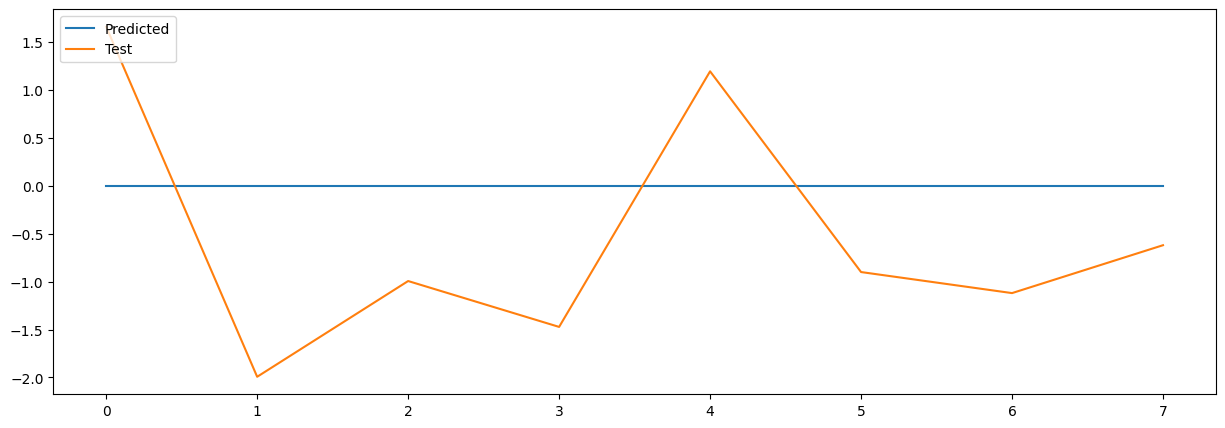

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y_pred, label='Predicted')
ax.plot(df_test[target].values, label='Test')
plt.legend(loc='upper left')
plt.show()